# Lending Club Case Study

## Business Understanding

We are working for Lending club a finance company which specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:
•If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
•If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company


## Objective

The company wants to understand the driving factors (or driver variables) behind loan default (loan_status = 'Charged Off'), i.e. the variables which are strong indicators of default. The company can utilise this knowledge for its portfolio and risk assessment.


Import the necessary libraries

In [20]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px #plotting
from IPython.core.display import HTML
%matplotlib inline
# to ignore the warnings
warnings.filterwarnings('ignore')

In [21]:
#reading the data file into loan_variable
loanData= pd.read_csv('loan.csv')

In [22]:
# see the first 5 rows of the data with head function
loanData.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [23]:
# get the information of the data file
loanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [24]:
# rows and columns in the data
loanData.shape

(39717, 111)

## Data Cleaning

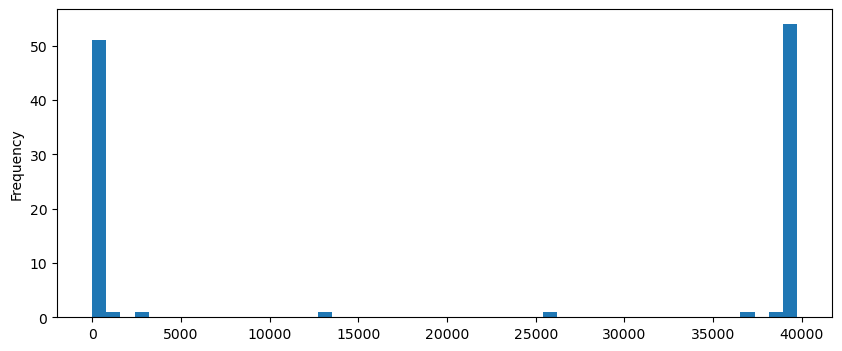

In [25]:
# get to know the null values and clean the data
null_col = loanData.isnull().sum()
null_col.plot(kind='hist', bins=50, figsize = (10,4))
plt.show()

From above, X-axis is the NULL values and Y-axis is the number of columns. 
We can clearly see that there is a huge spike towards the 40K mark. The total records in our data is 39,717.
Drop the columns which are having more null records


In [26]:
null_col.loc[(null_col.values > 10000) & (null_col.values < 39717)].sort_values()

desc                      12942
mths_since_last_delinq    25682
mths_since_last_record    36931
next_pymnt_d              38577
dtype: int64

Let us drop all columns having above 10K NULL values in them.

In [27]:
loanData.drop(columns=list(null_col[null_col.values > 10000].index), inplace=True)
loanData.shape

(39717, 53)

Look for the columns with unique values

In [28]:
column_unique = loanData.nunique()
print(column_unique)

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
delinq_2yrs                      11
earliest_cr_line                526
inq_last_6mths                    9
open_acc                    

we have columns with single value, we can drop them as there is no use of it

In [29]:
single_val_cols = column_unique[column_unique.values == 1]
single_val_cols.index

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

drop above columns with values "1"

In [30]:
loanData.drop(columns = list(single_val_cols.index), inplace=True)
loanData.shape

(39717, 44)

we had removed unnecessary columns and the no of columns count came down to 44 from 111

The company wants to know which loan applications are risky. Therefore, the fields that are created after a loan application is approved doesn't make sense for our analysis towards the business objective. Secondly, fields like id, member_id & url are different for each application. zip_code could have been a useful driver, but it contains only partial data which might impute our analysis negatively. Therefore, let us drop all these columns mentioned below

In [31]:
del_cols = ["id","member_id","url","zip_code","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
            "total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee",
            "last_pymnt_d","last_pymnt_amnt","last_credit_pull_d"]
loanData.drop(columns=del_cols, inplace=True)
loanData.shape

(39717, 28)

In [32]:
loanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39717 non-null  int64  
 1   funded_amnt           39717 non-null  int64  
 2   funded_amnt_inv       39717 non-null  float64
 3   term                  39717 non-null  object 
 4   int_rate              39717 non-null  object 
 5   installment           39717 non-null  float64
 6   grade                 39717 non-null  object 
 7   sub_grade             39717 non-null  object 
 8   emp_title             37258 non-null  object 
 9   emp_length            38642 non-null  object 
 10  home_ownership        39717 non-null  object 
 11  annual_inc            39717 non-null  float64
 12  verification_status   39717 non-null  object 
 13  issue_d               39717 non-null  object 
 14  loan_status           39717 non-null  object 
 15  purpose            

In [33]:
loanData.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,pub_rec_bankruptcies
count,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39020.000000
mean,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,9.294408,0.055065,13382.528086,22.088828,0.043260
std,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,4.400282,0.237200,15885.016641,11.401709,0.204324
min,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000
25%,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,6.000000,0.000000,3703.000000,13.000000,0.000000
50%,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,9.000000,0.000000,8850.000000,20.000000,0.000000
75%,15000.000000,15000.000000,14400.000000,430.780000,8.230000e+04,18.600000,0.000000,1.000000,12.000000,0.000000,17058.000000,29.000000,0.000000
max,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,90.000000,2.000000


### Data preparation 
let us start with loan status columns to begin with

In [34]:
loanData['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

As we are trying to find out the defaulters, the loan status 'current' is doesn't help much with our analysis because the applicants are already approved for loan and they are paying it.

In [35]:
loanData = loanData[~(loanData['loan_status'] == 'Current')]
loanData.shape

(38577, 28)

Let us look at other columns for our analysis... take term and see how it can infulence our decision manking..

In [36]:
loanData['term'].value_counts()

term
 36 months    29096
 60 months     9481
Name: count, dtype: int64

In [37]:
loanData['int_rate'].head()

0    10.65%
1    15.27%
2    15.96%
3    13.49%
5     7.90%
Name: int_rate, dtype: object

In [38]:
#Let's remvoe %
loanData['int_rate'] = loanData['int_rate'].apply(lambda x: pd.to_numeric(x.split("%")[0]))
loanData['int_rate'].describe()

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64

<Axes: >

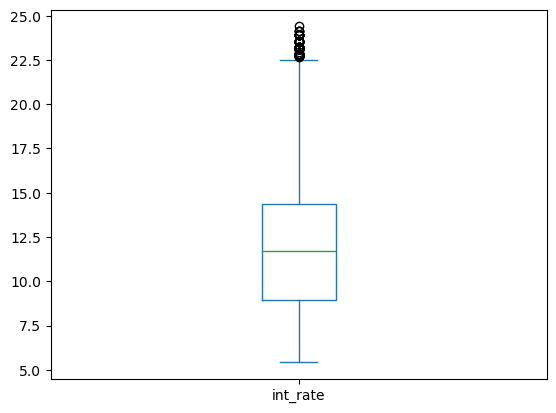

In [39]:
loanData['int_rate'].plot.box()

we can see some outlier values in int_rate column which needs to analysed when we do univariate analysis

In [40]:
loanData['grade'].value_counts()

grade
B    11675
A    10045
C     7834
D     5085
E     2663
F      976
G      299
Name: count, dtype: int64

In [41]:
loanData['sub_grade'].value_counts()

sub_grade
A4    2873
B3    2825
A5    2715
B5    2615
B4    2437
C1    2055
B2    2001
C2    1931
A3    1810
B1    1797
A2    1508
C3    1488
D2    1286
C4    1206
C5    1154
A1    1139
D3    1116
D1     931
D4     918
D5     834
E1     722
E2     614
E3     516
E4     424
E5     387
F1     305
F2     233
F3     174
F4     151
F5     113
G1      94
G2      77
G4      54
G3      45
G5      29
Name: count, dtype: int64

In [42]:
print(loanData['emp_title'].value_counts().head())
print(loanData['emp_title'].unique().shape)

emp_title
US Army              131
Bank of America      107
IBM                   65
AT&T                  57
Kaiser Permanente     56
Name: count, dtype: int64
(28028,)


In [43]:
loanData['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '1 year', '6 years', '2 years', '7 years',
       nan], dtype=object)

In [44]:
loanData['emp_length'].isnull().sum()

1033

In [45]:
loanData.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'pub_rec_bankruptcies'],
      dtype='object')

In [46]:
loanData['home_ownership'].value_counts()

home_ownership
RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: count, dtype: int64

In [47]:
loanData['verification_status'].value_counts()

verification_status
Not Verified       16694
Verified           12206
Source Verified     9677
Name: count, dtype: int64

In [48]:
loanData['issue_d'].head()

0    Dec-11
1    Dec-11
2    Dec-11
3    Dec-11
5    Dec-11
Name: issue_d, dtype: object

get the month and year from the issued date

In [49]:
loanData.issue_d=pd.to_datetime(loanData.issue_d,format='%b-%y')
loanData['issue_y']=pd.to_datetime(loanData.issue_d,format='%b-%y').dt.year
loanData['issue_m']=pd.to_datetime(loanData.issue_d,format='%b-%y').dt.month

In [50]:
loanData['earliest_cr_line'].value_counts()

earliest_cr_line
Oct-99    360
Nov-98    357
Oct-00    341
Dec-98    340
Dec-97    318
         ... 
Nov-65      1
Feb-73      1
Oct-08      1
Dec-61      1
Oct-74      1
Name: count, Length: 524, dtype: int64

In the earliest_cr_line field, we do see some data format inconsistencies. Sometimes it has MMM-YY and at other times it has YY-MMM. Also, the year is a 2 digit and not Y2K corrected. Therefre, we would need to apply some logic to extract meaningful data from here

In [51]:
from datetime import datetime
today = datetime.today()
today.year

2024

In [52]:
def days_from_earliest_cr_line (d):
    m, y = d.split('-')
    if y in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
        y, m = d.split('-')
    y = 2000 + int(y)
    if y > today.year:
        y -= 100
    earliest_cr_line = datetime.strptime(str(y)+'-'+m+'-1', '%Y-%b-%d')
    return (today - earliest_cr_line).days
days_from_earliest_cr_line("Dec-20")

1303

In [53]:
loanData['days_from_earliest_cr_line'] = loanData['earliest_cr_line'].apply(days_from_earliest_cr_line)
loanData['days_from_earliest_cr_line'].describe()

count    38577.000000
mean     10003.981647
std       2491.854695
min       5716.000000
25%       8334.000000
50%       9553.000000
75%      11165.000000
max      28666.000000
Name: days_from_earliest_cr_line, dtype: float64

In [54]:
loanData.drop(columns=['earliest_cr_line'], inplace=True)

In [55]:
loanData['revol_util'].head()

0    83.70%
1     9.40%
2    98.50%
3       21%
5    28.30%
Name: revol_util, dtype: object

In [56]:
#let us convert these values in numberics by removing %
loanData['revol_util'] = pd.Series(loanData['revol_util']).str.replace('%', '').astype(float)
loanData['revol_util'].describe()

count    38527.000000
mean        48.702777
std         28.364741
min          0.000000
25%         25.200000
50%         49.100000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

In [57]:
loanData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38577 entries, 0 to 39716
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   loan_amnt                   38577 non-null  int64         
 1   funded_amnt                 38577 non-null  int64         
 2   funded_amnt_inv             38577 non-null  float64       
 3   term                        38577 non-null  object        
 4   int_rate                    38577 non-null  float64       
 5   installment                 38577 non-null  float64       
 6   grade                       38577 non-null  object        
 7   sub_grade                   38577 non-null  object        
 8   emp_title                   36191 non-null  object        
 9   emp_length                  37544 non-null  object        
 10  home_ownership              38577 non-null  object        
 11  annual_inc                  38577 non-null  float64       


In [58]:
loanData.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m,days_from_earliest_cr_line
count,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,3.857700e+04,38577,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38527.000000,38577.000000,37880.000000,38577.000000,38577.000000,38577.000000
mean,11047.025430,10784.058506,10222.481123,11.932219,322.466318,6.877797e+04,2010-10-25 23:47:14.030640128,13.272727,0.146668,0.871737,9.275423,0.055422,13289.489826,48.702777,22.052648,0.043479,2010.309070,7.114757,10003.981647
min,500.000000,500.000000,0.000000,5.420000,15.690000,4.000000e+03,2007-06-01 00:00:00,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2007.000000,1.000000,5716.000000
25%,5300.000000,5200.000000,5000.000000,8.940000,165.740000,4.000000e+04,2010-05-01 00:00:00,8.130000,0.000000,0.000000,6.000000,0.000000,3650.000000,25.200000,13.000000,0.000000,2010.000000,4.000000,8334.000000
50%,9600.000000,9550.000000,8733.440000,11.710000,277.860000,5.886800e+04,2011-01-01 00:00:00,13.370000,0.000000,1.000000,9.000000,0.000000,8762.000000,49.100000,20.000000,0.000000,2011.000000,7.000000,9553.000000
75%,15000.000000,15000.000000,14000.000000,14.380000,425.550000,8.200000e+04,2011-08-01 00:00:00,18.560000,0.000000,1.000000,12.000000,0.000000,16912.000000,72.300000,29.000000,0.000000,2011.000000,10.000000,11165.000000
max,35000.000000,35000.000000,35000.000000,24.400000,1305.190000,6.000000e+06,2011-12-01 00:00:00,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,2.000000,2011.000000,12.000000,28666.000000
std,7348.441646,7090.306027,7022.720644,3.691327,208.639215,6.421868e+04,NaN,6.673044,0.492271,1.071546,4.401588,0.237804,15866.492241,28.364741,11.425861,0.204583,0.882658,3.408523,2491.854695


Let us now take the percentage of loans paid vs charged off for all the records before going into further analysis

In [59]:
loan_status_percent = loanData['loan_status'].value_counts(normalize=True)
loan_status_percent

loan_status
Fully Paid     0.854136
Charged Off    0.145864
Name: proportion, dtype: float64

# since we have cleaned data set and have parameters for our EDA. let's proceed with EDA


Univariate Analysis

Let us start by understanding the correlation between the different numeric fields and see if they are related (high correlation values)


In [60]:
# changing the loan_status to a numeric variable, assign 1 for defaulted loans and 0 for paid off ones
loanData['loan_status_num'] = loanData['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)

In [61]:
loanData.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m,days_from_earliest_cr_line,loan_status_num
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,3,0,13648,83.7,9,0.0,2011,12,14421,0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,3,0,1687,9.4,4,0.0,2011,12,9218,1
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,2,0,2956,98.5,10,0.0,2011,12,8273,0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,10,0,5598,21.0,37,0.0,2011,12,10373,0
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,9,0,7963,28.3,12,0.0,2011,12,7177,0


# Loan status vs Numerical continuous variables

Let us now compare the loan_status fields with all the numerical variable. Since the analysis for this category will be similar, let us contruct a common function which can be used for all.


In [62]:
# here are some of the global settings/constants that will be referred to within the functions defined below
#colors = ["#fca9a9","#a9fea9"]
colors = ["#a9fea9","#fca9a9"]
sns.set(style='whitegrid', palette=sns.color_palette(colors))
by = 'loan_status'
order = ['Fully Paid','Charged Off']
# loan_status_pct from above will be used in the below functions as well

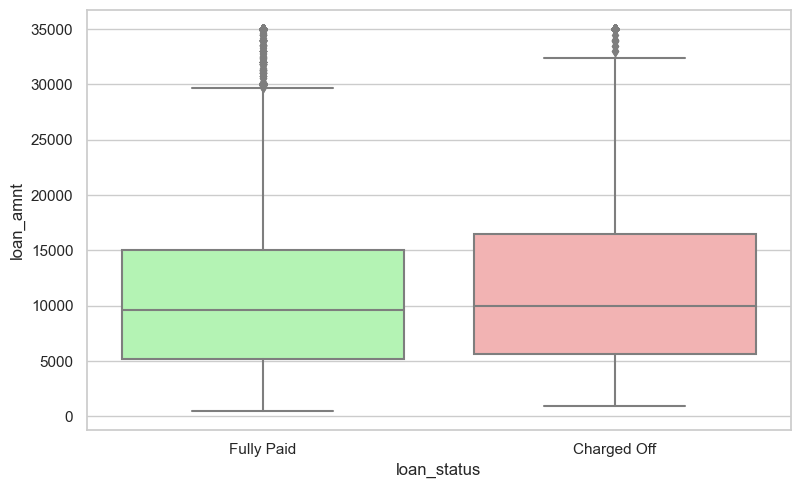

In [63]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', data = loanData)
plt.show()

In [64]:
loanData['loan_amnt'].describe()

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

since we see there is huge difference between mean and median . let us limit our data to 75%

In [65]:
loan_till75 = loanData.loc[(loanData['loan_amnt']<=15000)]

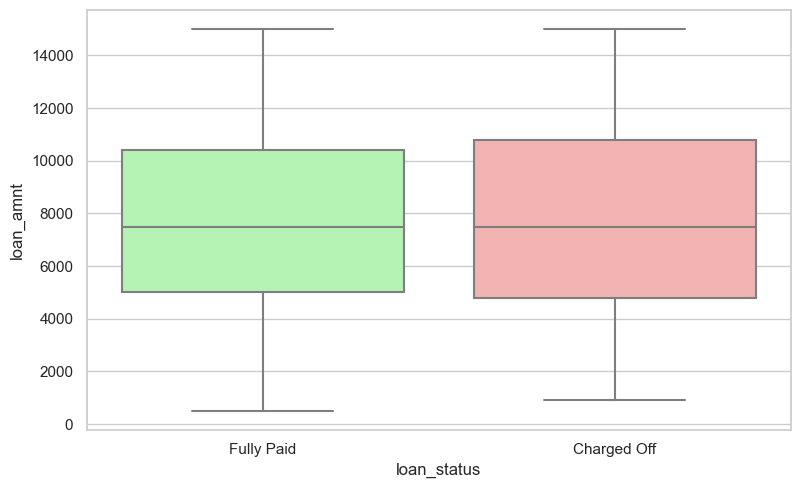

In [66]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', data = loan_till75)
plt.show()

since it is giving picture , let us take date data above 75%

In [67]:
loan_above75 = loanData.loc[(loanData['loan_amnt']>=15000)]
loan_above75.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m,days_from_earliest_cr_line,loan_status_num
20,20250,20250,19142.16108,60 months,15.27,484.63,C,C4,Archdiocese of Galveston Houston,3 years,...,8,0,17813,85.6,22,0.0,2011,12,9734,0
21,21000,21000,21000.00000,36 months,12.42,701.73,B,B4,Osram Sylvania,10+ years,...,7,0,32135,90.3,38,0.0,2011,12,15121,1
25,15000,15000,15000.00000,36 months,9.91,483.38,B,B1,Winfield Pathology Consultants,2 years,...,8,0,13707,93.9,31,0.0,2011,12,8181,0
26,15000,15000,8725.00000,36 months,14.27,514.64,C,C2,nyc transit,9 years,...,7,0,5872,57.6,11,0.0,2011,12,7574,1
31,31825,31825,31825.00000,36 months,7.90,995.82,A,A4,Audubon Mutual Housing Corporation,5 years,...,12,0,23151,27.4,26,0.0,2011,12,15578,0


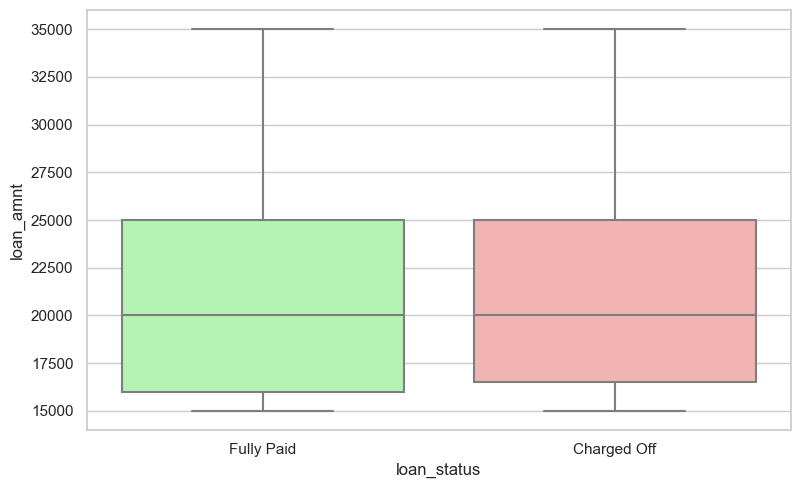

In [68]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', data = loan_above75)
plt.show()

### from above box plot we can conclude that "heigher the amount" will tend to "Write off"

since we have too many columns for univariate analysis let us define some default functions, so that we can re-use same function
for all the columns 

In [69]:
def PercentileCut (*, data=loanData, column, trailer=''):
    """
        Parameters:
            data : defaulted to 'loan'
            column : this is the continuous numeric field which has to be binned to its percentiles
            trailer : defaulted to blank, this will be added to the end of the percentile values
                      like '%' for interest rate related fields
        Returns:
            None
            It creates a new column in the data with a suffix '_p' and this contains the newly created category
    """
    new_column = column + '_p'
    labels = ['Lowest ','Lower ','Medium ','Higher ','Highest ']
    labels = [labels[p] + '(' +
              str(round(np.nanpercentile(data[column], p * 20),2)) +
              trailer + ' - ' +
              str(round(np.nanpercentile(data[column], (p+1) * 20),2)) +
              trailer + ')'
              for p in range(5)]
    data[new_column] = pd.qcut(data[column], q=5, labels=labels)

In [70]:
loanData.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'pub_rec_bankruptcies', 'issue_y', 'issue_m',
       'days_from_earliest_cr_line', 'loan_status_num'],
      dtype='object')

In [71]:
def Univariate_Categorical (*, data=loanData, column, title=None, figsize=(8,6), grp_comparison=True, box_plot=False,
                            pct_comparison=False, filter=None, disp_filter = None):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            column : need to provide the numerical column for comparison
            figsize : a default have is given, but can be overridden
            loan_status_pct : a global variable, which is referred here for the percentage comparison
            grp_comparison : with this as true, it groups the data based on the categories and compares
            pct_comparison : this will call the Pct_Comparison method and below couple parameters will be applicable for it
            filter : any conditions based on which the data will be filtered before plotting, ignored if None
            disp_filter : string for display purpose only, valid if filter is not None
        Returns:
            None, does a countplot and a box plot as well, if needed
    """
    plotdata = data if filter is None else data.loc[filter]
        
    if pct_comparison and filter is not None:
        Pct_Comparison(filter, disp_filter)

    if grp_comparison:
        fig, ax = plt.subplots(figsize=figsize)
        sns.countplot(data=plotdata, y=column, hue=by, ax=ax, 
                      order=plotdata[column].value_counts().index, hue_order=order)
        if title is not None:
            plt.title(title)
        plt.show()
        
        df = loanData.groupby([column])[by].value_counts(normalize=True
                                                    ).rename('Charged off %').reset_index().sort_values(column)
        df = df.loc[df[by]=='Charged Off'].sort_values(by='Charged off %', ascending=False).drop(columns=[by])
        df2 = loanData.groupby([column])[by].count()
        df = df.merge(right=df2,on=column).rename(columns={by:'Record count'})
        display(HTML(df.to_html(index=False)))
        
        if box_plot:
            df2.plot(kind='box',logy=True,x="No. of records of defaulted loans per category")
            plt.show()        

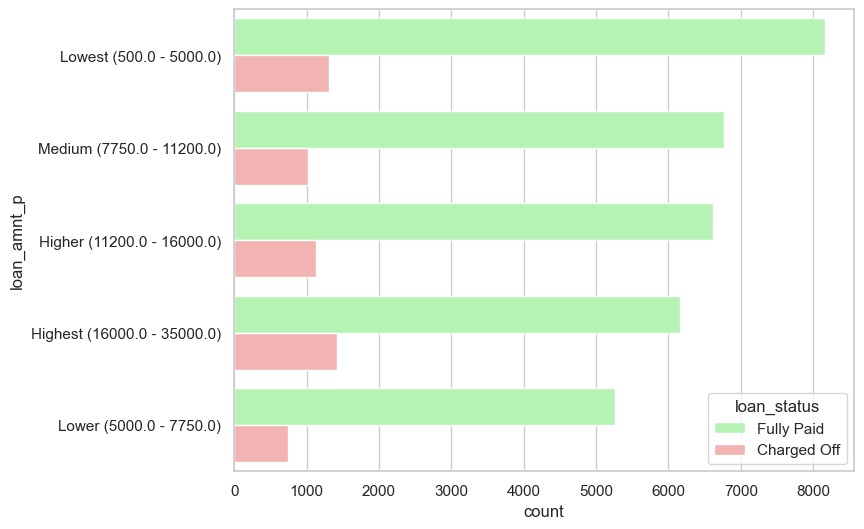

loan_amnt_p,Charged off %,Record count
Highest (16000.0 - 35000.0),0.187624,7579
Higher (11200.0 - 16000.0),0.145368,7739
Lowest (500.0 - 5000.0),0.138725,9472
Medium (7750.0 - 11200.0),0.131613,7788
Lower (5000.0 - 7750.0),0.123521,5999


In [72]:
PercentileCut(column='loan_amnt')
Univariate_Categorical(column='loan_amnt_p')

Higher the loan amount, greater the chance of the loan getting default.

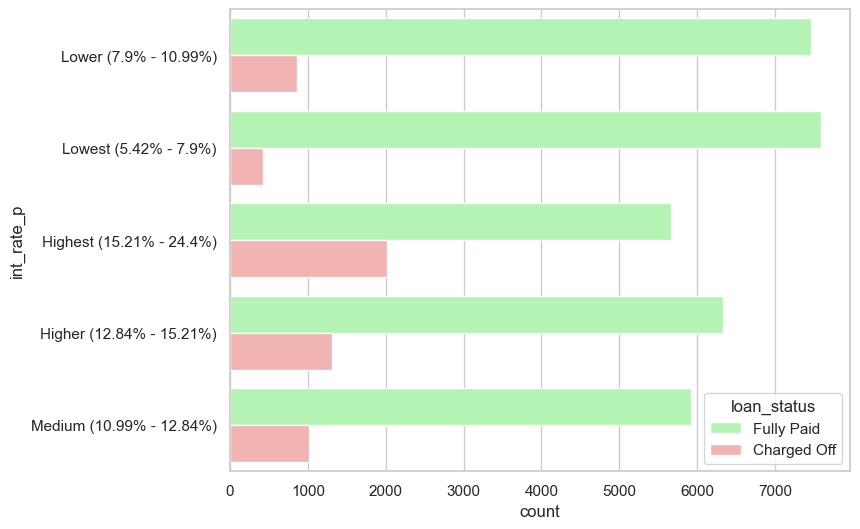

int_rate_p,Charged off %,Record count
Highest (15.21% - 24.4%),0.262150,7675
Higher (12.84% - 15.21%),0.171619,7639
Medium (10.99% - 12.84%),0.146995,6939
Lower (7.9% - 10.99%),0.102876,8311
Lowest (5.42% - 7.9%),0.053538,8013


In [73]:
PercentileCut(column='int_rate', trailer='%')
Univariate_Categorical(column='int_rate_p')

Higher the interest rate leads to higher charged off%

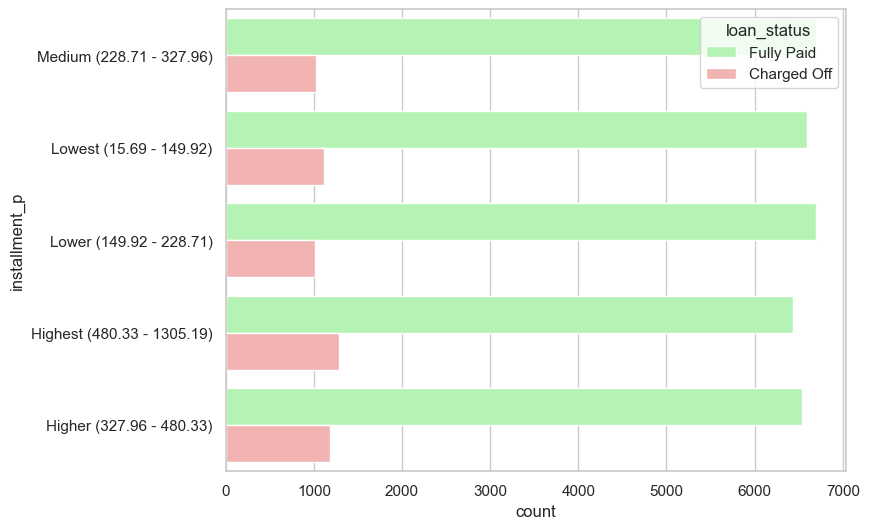

installment_p,Charged off %,Record count
Highest (480.33 - 1305.19),0.166321,7714
Higher (327.96 - 480.33),0.152988,7713
Lowest (15.69 - 149.92),0.145153,7716
Medium (228.71 - 327.96),0.132936,7718
Lower (149.92 - 228.71),0.131934,7716


In [74]:
PercentileCut(column='installment')
Univariate_Categorical(column='installment_p')

Above data and plot shows that higher installment amounts shows higher default percentages.

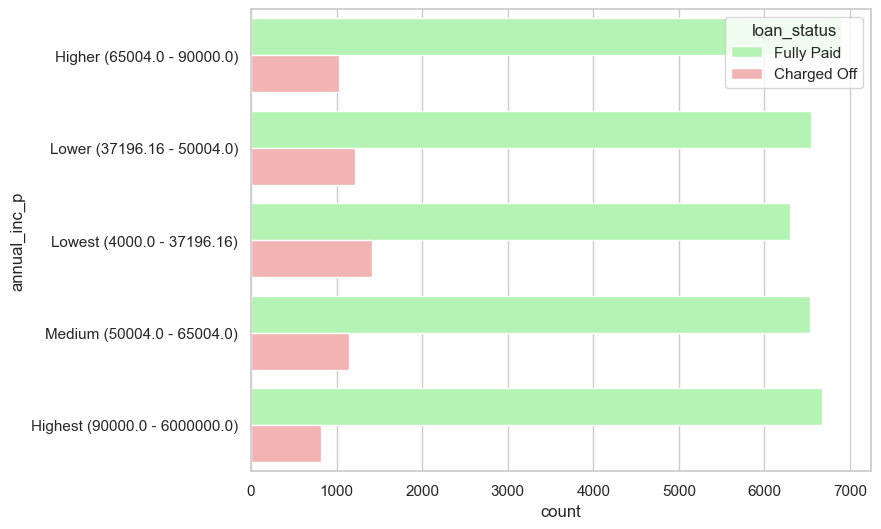

annual_inc_p,Charged off %,Record count
Lowest (4000.0 - 37196.16),0.183126,7716
Lower (37196.16 - 50004.0),0.156926,7768
Medium (50004.0 - 65004.0),0.149629,7679
Higher (65004.0 - 90000.0),0.129651,7929
Highest (90000.0 - 6000000.0),0.109285,7485


In [75]:
PercentileCut(column='annual_inc')
Univariate_Categorical(column='annual_inc_p')

Higher the income hiegher the repayment %

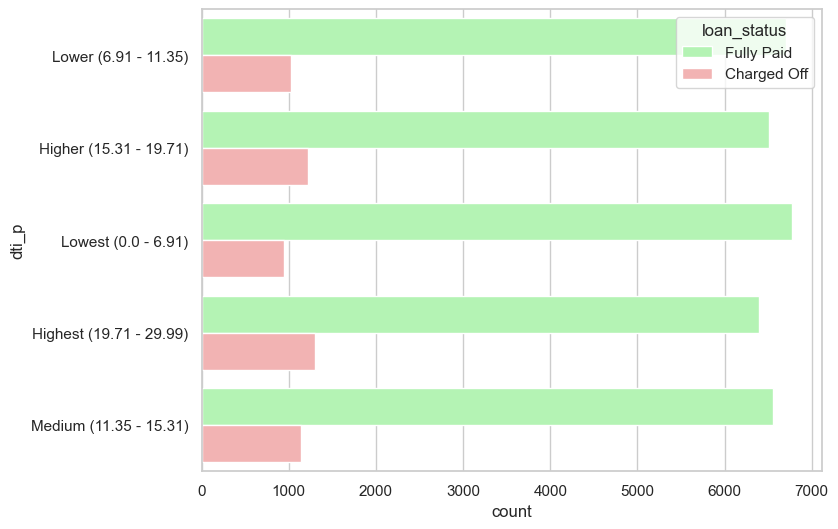

dti_p,Charged off %,Record count
Highest (19.71 - 29.99),0.168853,7699
Higher (15.31 - 19.71),0.157908,7726
Medium (11.35 - 15.31),0.147609,7696
Lower (6.91 - 11.35),0.132627,7736
Lowest (0.0 - 6.91),0.122409,7720


In [76]:
PercentileCut(column='dti')
Univariate_Categorical(column='dti_p')

higher DTI ( debt to income ratio) will lead to higher charged off %

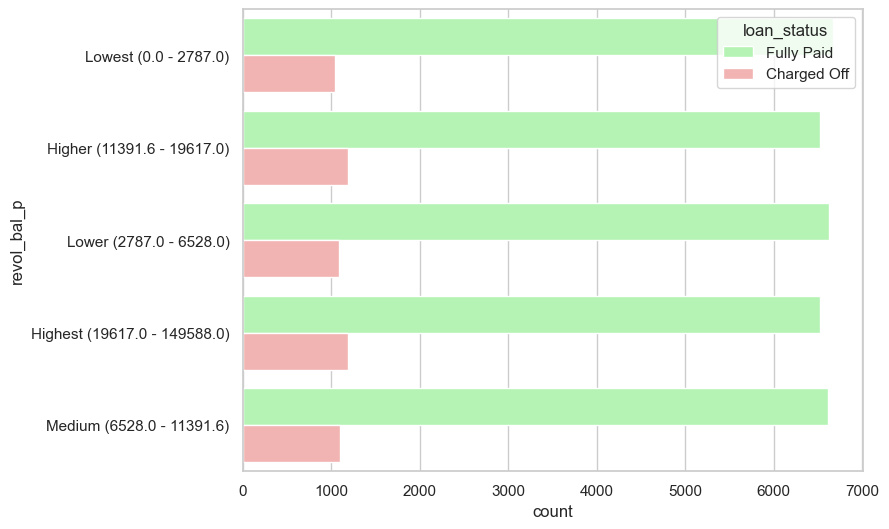

revol_bal_p,Charged off %,Record count
Highest (19617.0 - 149588.0),0.154913,7714
Higher (11391.6 - 19617.0),0.154335,7717
Medium (6528.0 - 11391.6),0.142894,7712
Lower (2787.0 - 6528.0),0.141283,7715
Lowest (0.0 - 2787.0),0.135898,7719


In [77]:
PercentileCut(column='revol_bal')
Univariate_Categorical(column='revol_bal_p')

This shows the total credit revolving balances slightly influence the default percentage. Higher the revolving balance, bigger the chance of the loan getting defaulted.

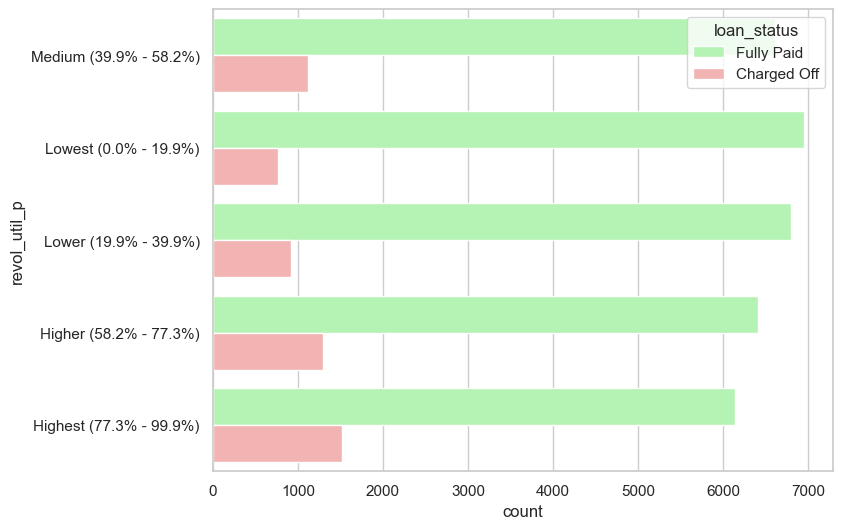

revol_util_p,Charged off %,Record count
Highest (77.3% - 99.9%),0.198069,7664
Higher (58.2% - 77.3%),0.167727,7703
Medium (39.9% - 58.2%),0.145001,7731
Lower (19.9% - 39.9%),0.118356,7714
Lowest (0.0% - 19.9%),0.099417,7715


In [78]:
PercentileCut(column='revol_util',trailer='%')
Univariate_Categorical(column='revol_util_p')

This data shows that the revolving line utilization rate has a large impact to the default percentage. When this increases, the charged off percentage rises.

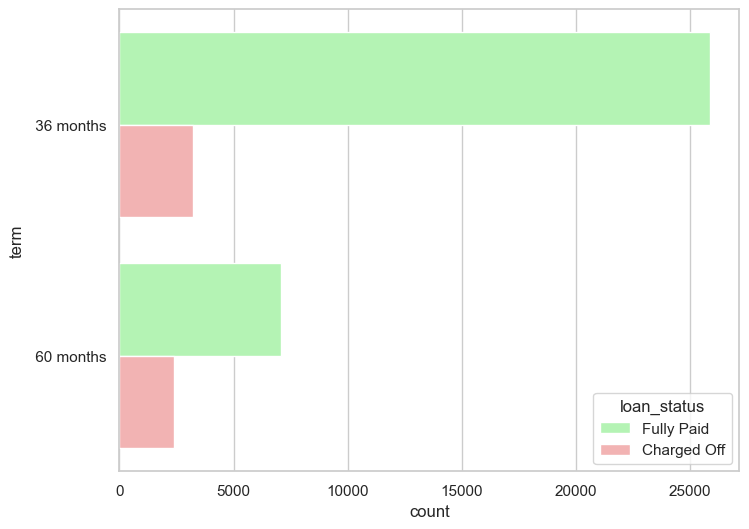

term,Charged off %,Record count
60 months,0.253138,9481
36 months,0.110909,29096


In [79]:
Univariate_Categorical(column='term')

For loans with 5 year repayment term, the default percent is 25%. And for 3 year loan repayment term, the default is only for 11% of the cases. 
Therefore, loan repayment term plays a factor in judging the default rate.

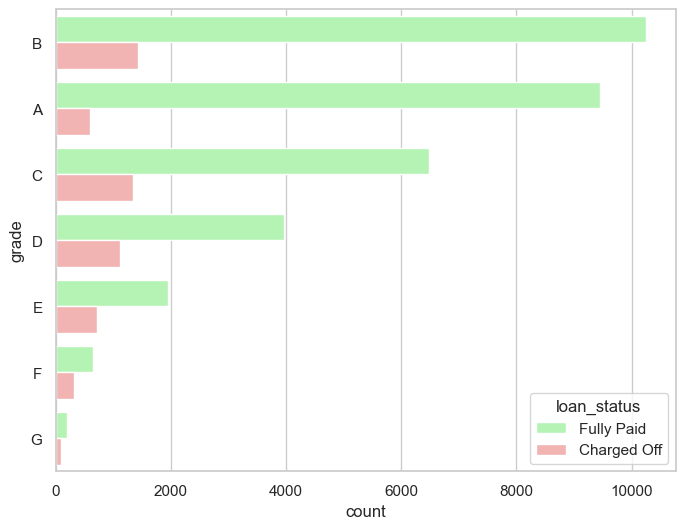

grade,Charged off %,Record count
G,0.337793,299
F,0.326844,976
E,0.268494,2663
D,0.219862,5085
C,0.171943,7834
B,0.122056,11675
A,0.059930,10045


In [80]:
Univariate_Categorical(column='grade')

We can clearly see that loan grades having highest default percentages. G, F, E and D form grades where default rate is much higher than others.


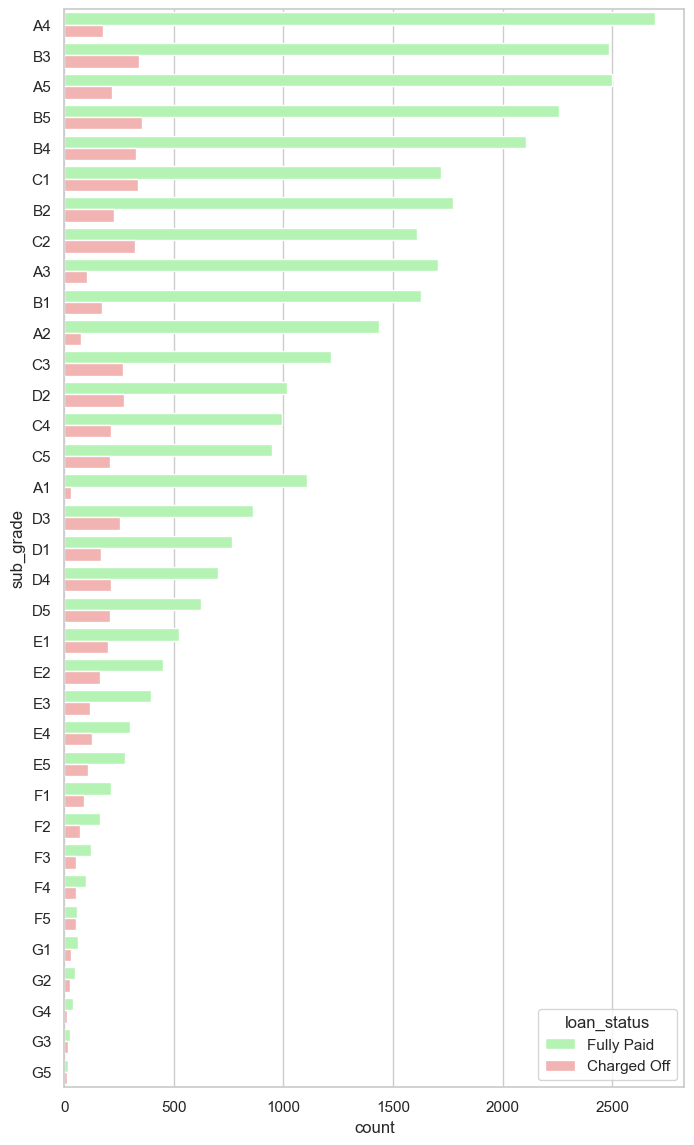

sub_grade,Charged off %,Record count
F5,0.477876,113
G3,0.422222,45
G2,0.363636,77
F4,0.350993,151
G5,0.344828,29
G1,0.329787,94
F2,0.300429,233
F1,0.298361,305
E4,0.297170,424
F3,0.293103,174


In [81]:
Univariate_Categorical(column='sub_grade', figsize=(8,14))

The above table shows the loan sub-grade versus the default percentage. The G3 and F5 sub categories have above 40% default rate. This field is a clear indicator of the default percent.

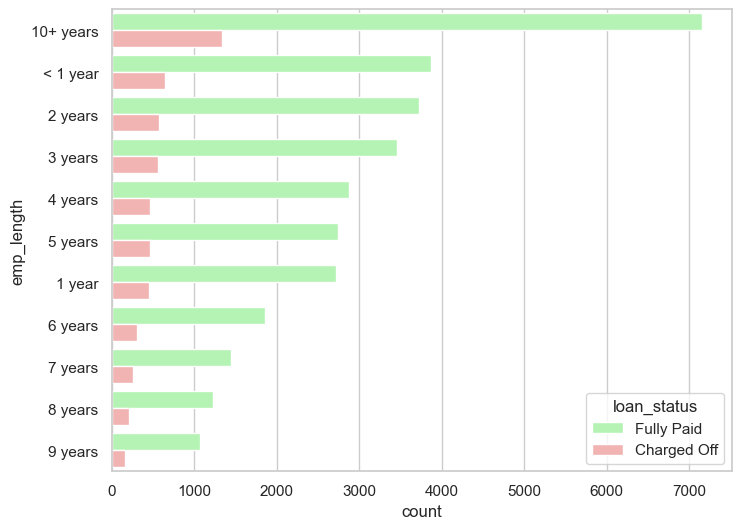

emp_length,Charged off %,Record count
10+ years,0.156810,8488
7 years,0.153711,1711
1 year,0.143894,3169
5 years,0.143394,3194
< 1 year,0.141748,4508
6 years,0.141605,2168
8 years,0.141463,1435
3 years,0.138335,4012
4 years,0.138241,3342
2 years,0.132137,4291


In [82]:
Univariate_Categorical(column='emp_length')

although there is nothing much to conclude from above data, we can see having no employment will lead to Defaulted payment

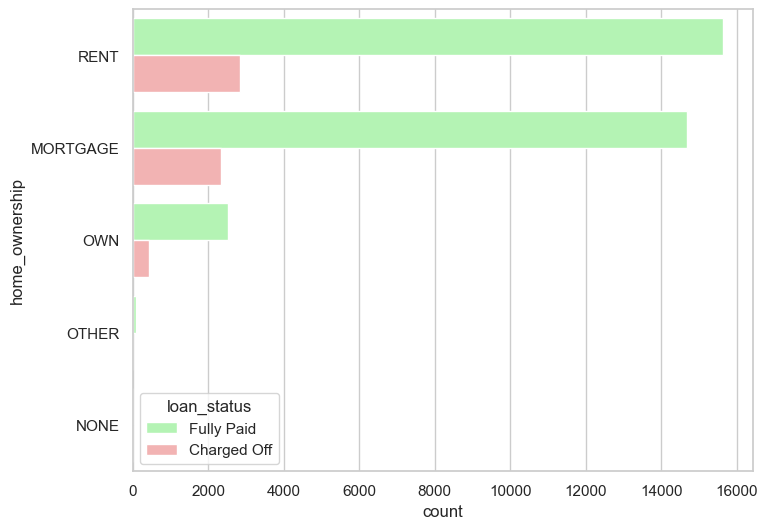

home_ownership,Charged off %,Record count
OTHER,0.183673,98
RENT,0.153626,18480
OWN,0.148908,2975
MORTGAGE,0.136713,17021


In [83]:
Univariate_Categorical(column='home_ownership')

we have not much info to conclude as it says "OTHER", 

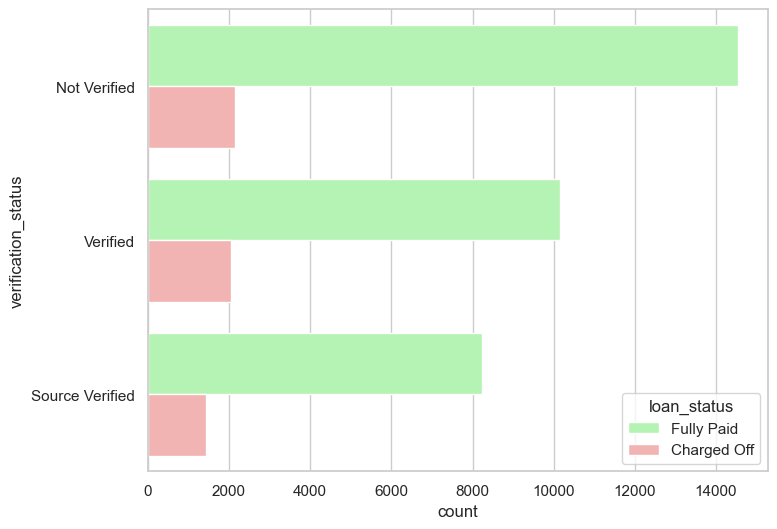

verification_status,Charged off %,Record count
Verified,0.168032,12206
Source Verified,0.148186,9677
Not Verified,0.128310,16694


In [84]:
Univariate_Categorical(column='verification_status')

interestingly verified applicants have more defaulted % which means the verifiaction process is not correct.

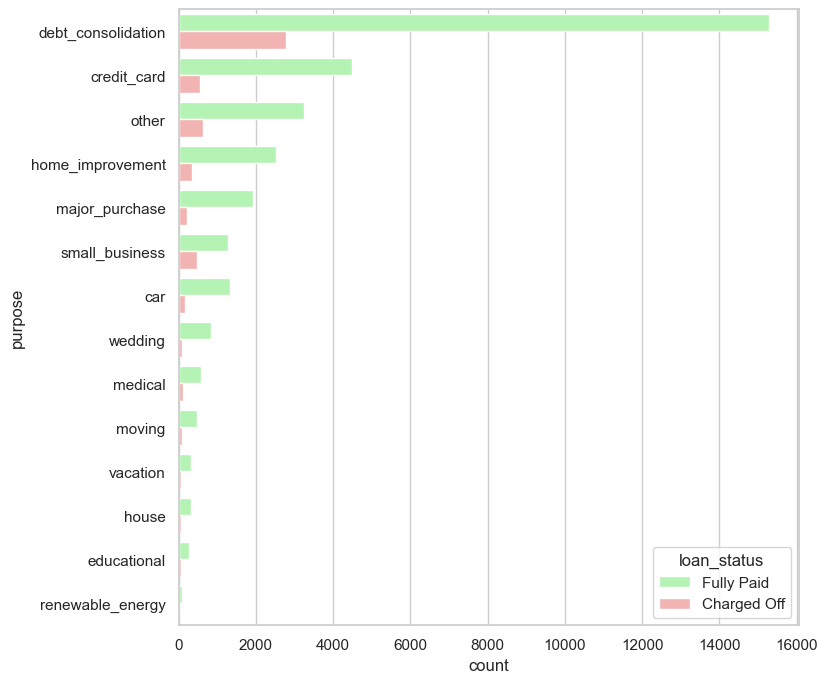

purpose,Charged off %,Record count
small_business,0.270810,1754
renewable_energy,0.186275,102
educational,0.172308,325
other,0.163777,3865
house,0.160763,367
moving,0.159722,576
medical,0.155653,681
debt_consolidation,0.153254,18055
vacation,0.141333,375
home_improvement,0.120696,2875


In [85]:
Univariate_Categorical(column='purpose', figsize=(8,8))

From the above analysis it is evidend that the loans taken for small_business, renewable_energy and educational are the riskier ones.

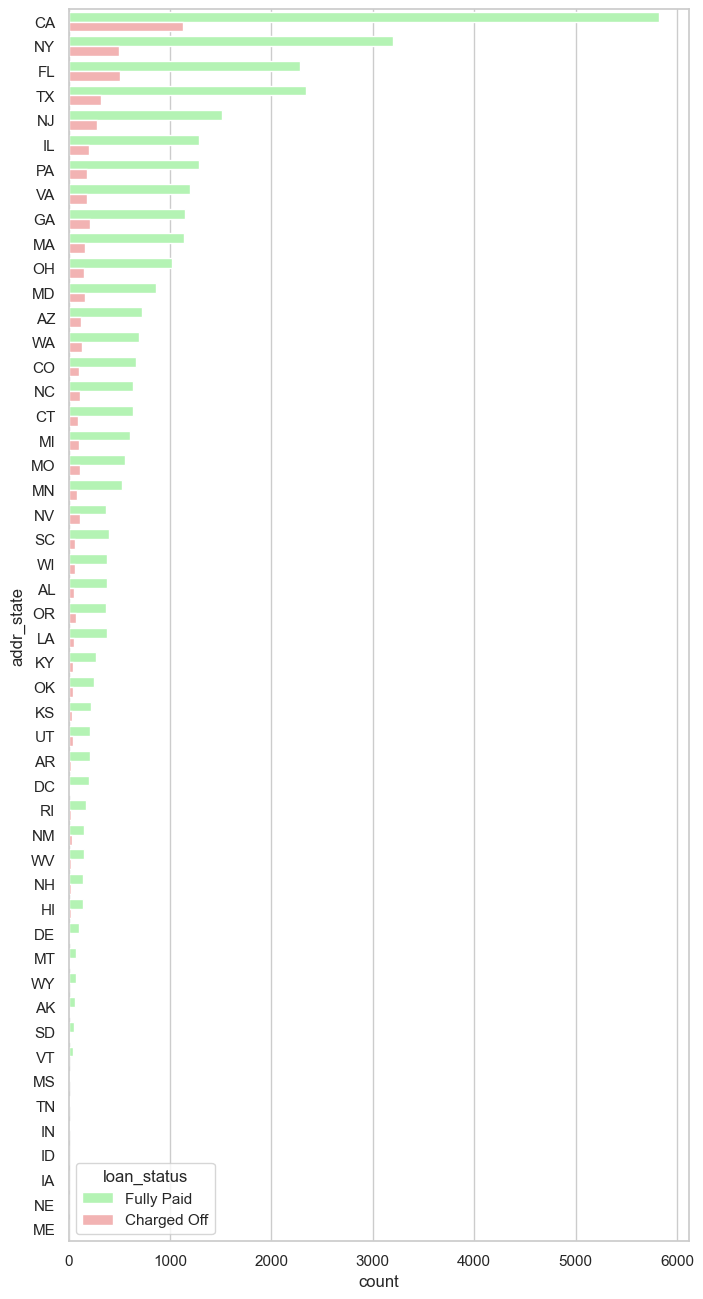

addr_state,Charged off %,Record count
NE,0.600000,5
NV,0.225470,479
SD,0.193548,62
AK,0.192308,78
FL,0.181230,2781
MO,0.170149,670
HI,0.168675,166
ID,0.166667,6
NM,0.163934,183
OR,0.163218,435


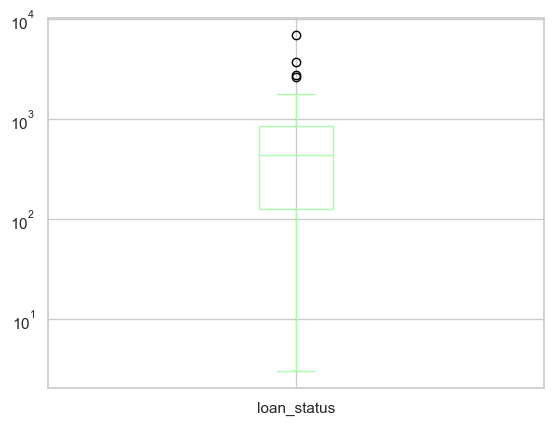

In [86]:
Univariate_Categorical(column='addr_state',figsize=(8,16), box_plot=True)

From the above table we can see that the some of the risky states are NE, NV, SD, AK, FL, MO

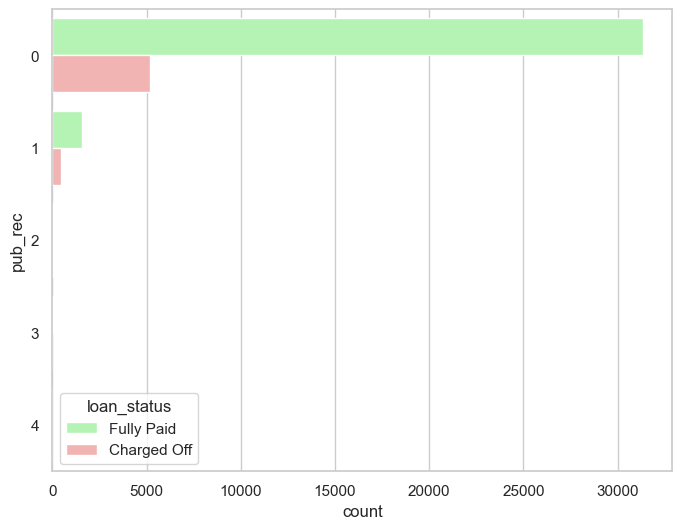

pub_rec,Charged off %,Record count
1,0.227024,2013
2,0.208333,48
0,0.141343,36507


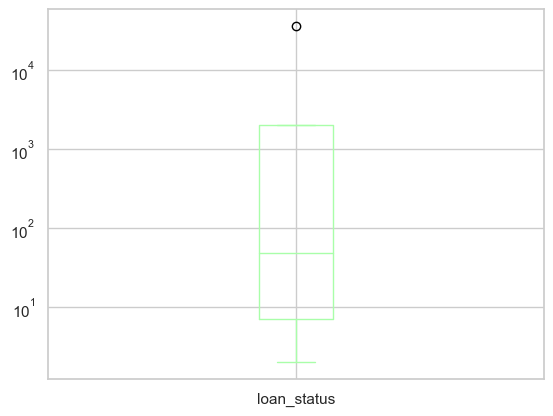

In [87]:
Univariate_Categorical(column='pub_rec', box_plot=True)

Above data and graph crealy shows that individuals with non-zero derogatory public records have higher chances of charged off

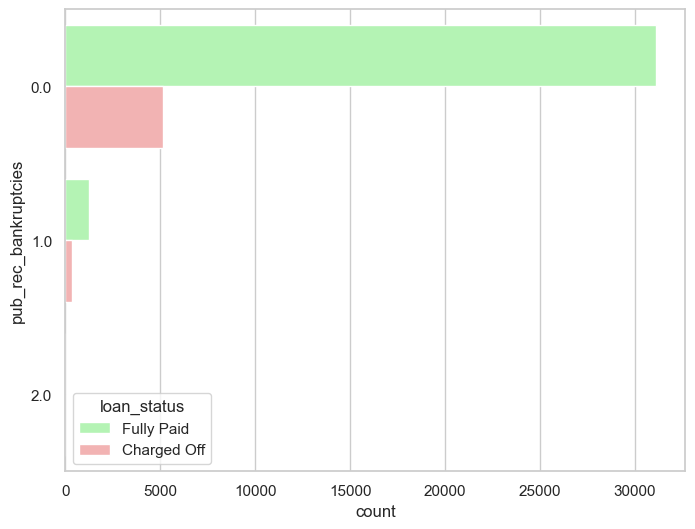

pub_rec_bankruptcies,Charged off %,Record count
2.0,0.400000,5
1.0,0.223580,1637
0.0,0.141868,36238


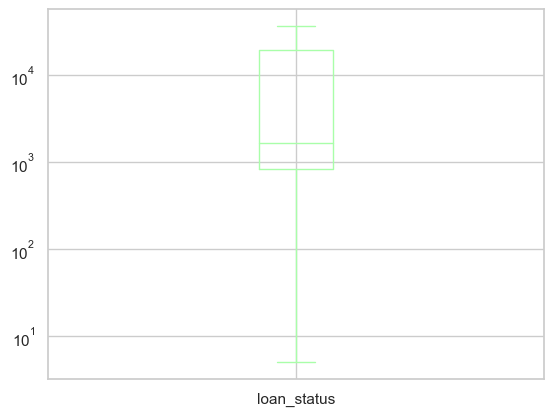

In [88]:
Univariate_Categorical(column='pub_rec_bankruptcies', box_plot=True)

Higher the number of public bankruptcy records, bigger the chance of defaulting the loan.

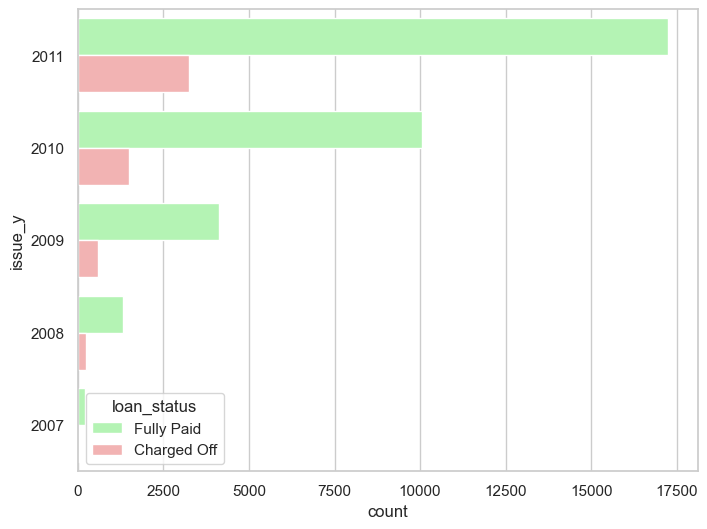

issue_y,Charged off %,Record count
2007,0.179283,251
2011,0.158705,20516
2008,0.158131,1562
2010,0.128772,11532
2009,0.125954,4716


In [89]:
Univariate_Categorical(column='issue_y')

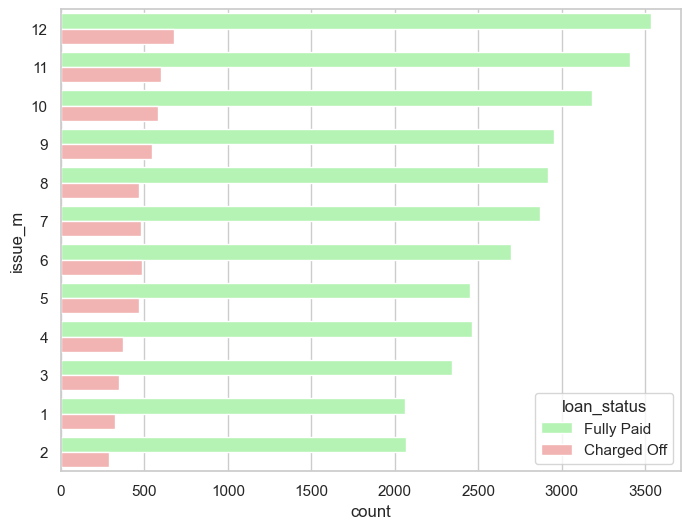

issue_m,Charged off %,Record count
12,0.160854,4215
5,0.159644,2919
9,0.156375,3498
10,0.154214,3761
6,0.151887,3180
11,0.149276,4006
7,0.142942,3351
8,0.138135,3388
1,0.134931,2379
4,0.130696,2831


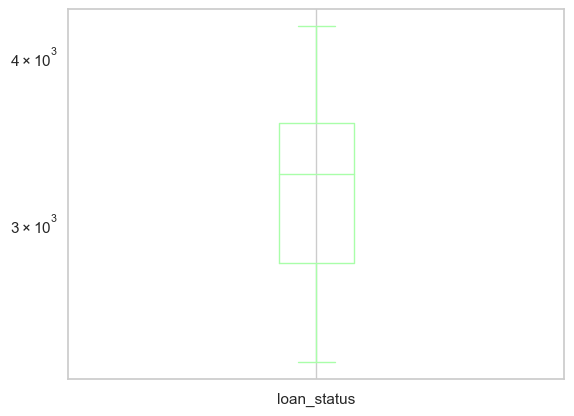

In [90]:
Univariate_Categorical(column='issue_m', box_plot=True)

we can clearly see December is the month which has the highest number of loan applications per year and also have the biggest default ratio. May be people take loan for travel/party during Christmas and then are not able to pay back. Month of May is also another one, which is during the summer break and right before the Memorial day and Independance day breaks in US where people love to travel.

# Bivariate Analysis

Now that we have analyzed each of the variables and its impact on the loan-status, let us take group of variables together and and analyze their combined effect on the loan-status. These categories are based on our business understanding. The original distribution column shows the average trend in all the data and we compare that with the data after applying our conditions.


In [91]:
def Bivariate_Analysis (*, data=loanData, x, y, title=None, figsize=(8,6)):
    """
        Parameters:
            data : defaulted at the 'loanData' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, one numerical and one categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a violin plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(data=loanData, x=x, y=y, hue=by, split=True, figsize=figsize,
                   ax=ax, hue_order=order)
    if title is not None:
        plt.title(title)
    plt.show()

In [92]:
def Bivariate_Categorical (*, data=loanData, x, y, title=None, figsize=(8,6)):
    """
        Parameters:
            data : defaulted at the 'loanData' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, both categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a heatmap plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    pt = pd.pivot_table(data=loanData, values='loan_status_num', index=y, columns=x)
    sns.heatmap(pt, ax=ax, cmap='YlGnBu')
    if title is not None:
        plt.title(title)
    plt.show()

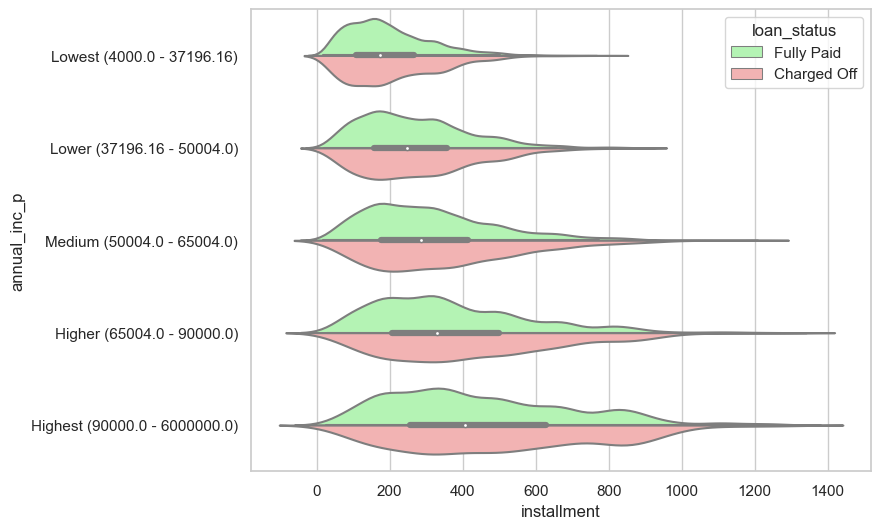

In [93]:
Bivariate_Analysis(x='installment', y='annual_inc_p')
plt.show()

Above figure shows that for higher installments for any income group have more number of defaults.

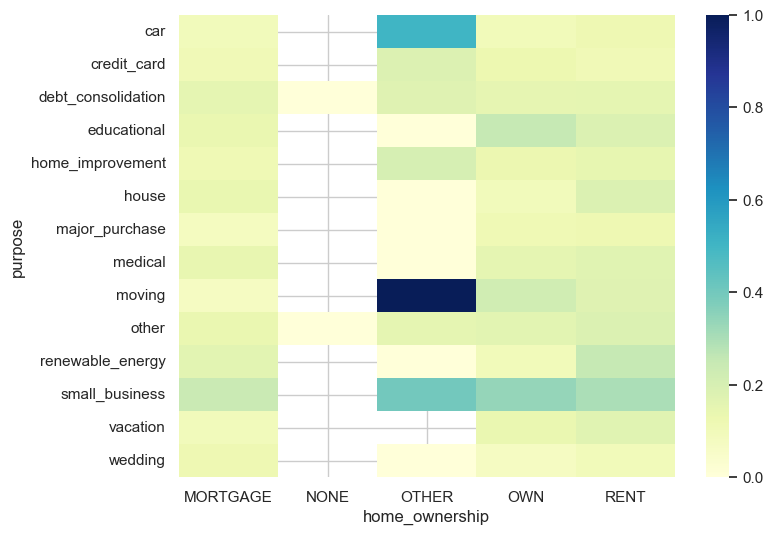

In [94]:
Bivariate_Categorical(x='home_ownership', y='purpose')

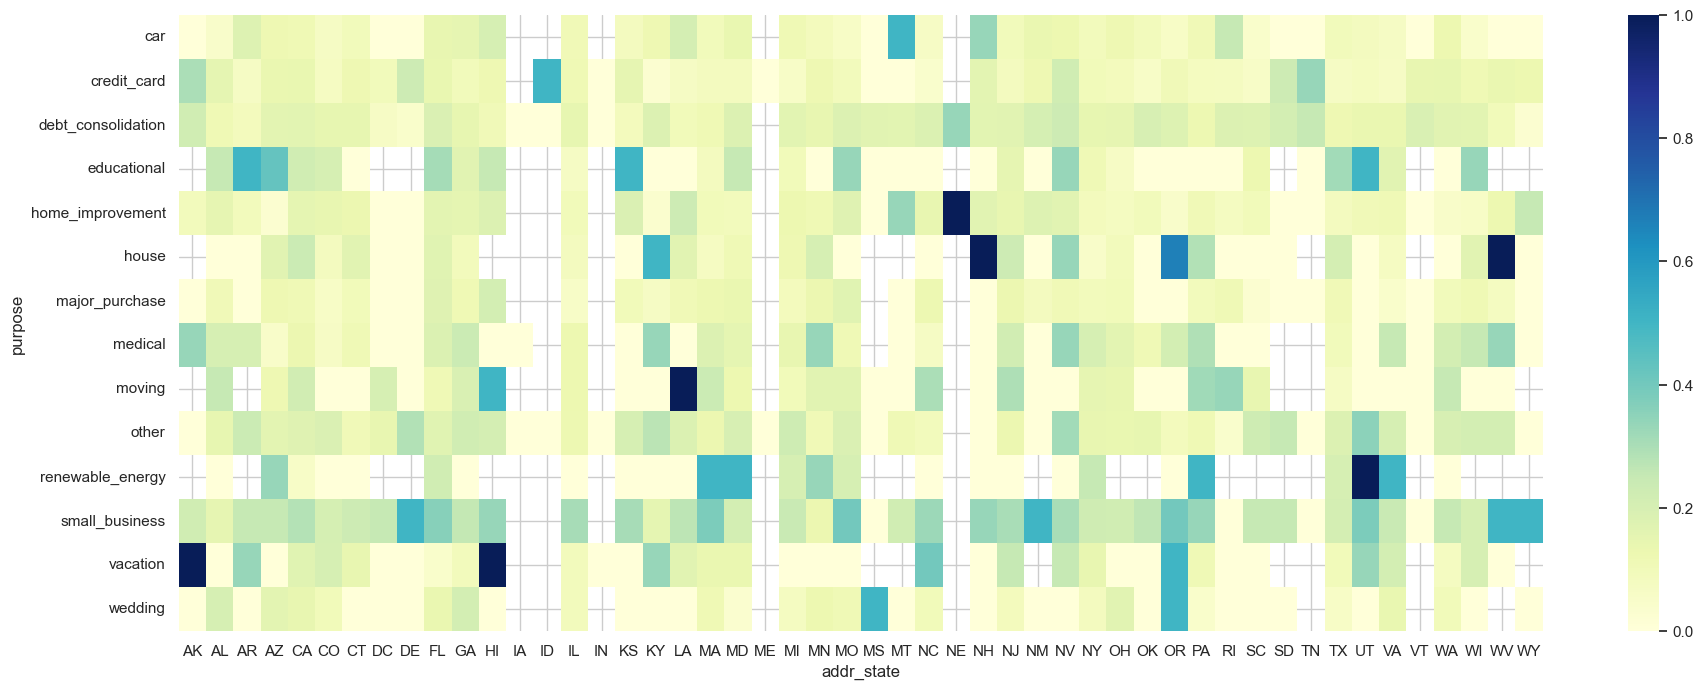

In [95]:
Bivariate_Categorical(x='addr_state', y='purpose', figsize=(22,8))

As per the above plot, the darker the intersection of addr_state has with the purpose of the loan, the risker the loan application is. Some of the examples are below:
•vacation loans in AK, HI, OR
•education loans in AR, KS, UT
•small business loans in DE, NM, WV, wY
•wedding loans in MS, OR


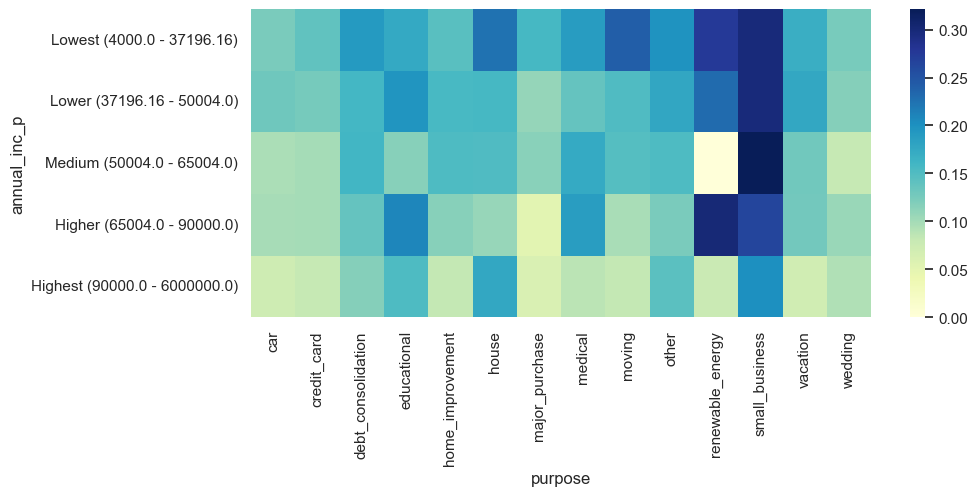

In [96]:
Bivariate_Categorical(x='purpose', y='annual_inc_p', figsize=(10,4))

Plot of various income groups versus the risky purposes of loans for them. Some examples are:
•small business loans for lowest and medium income groups
•renewable energy loans for higher income group


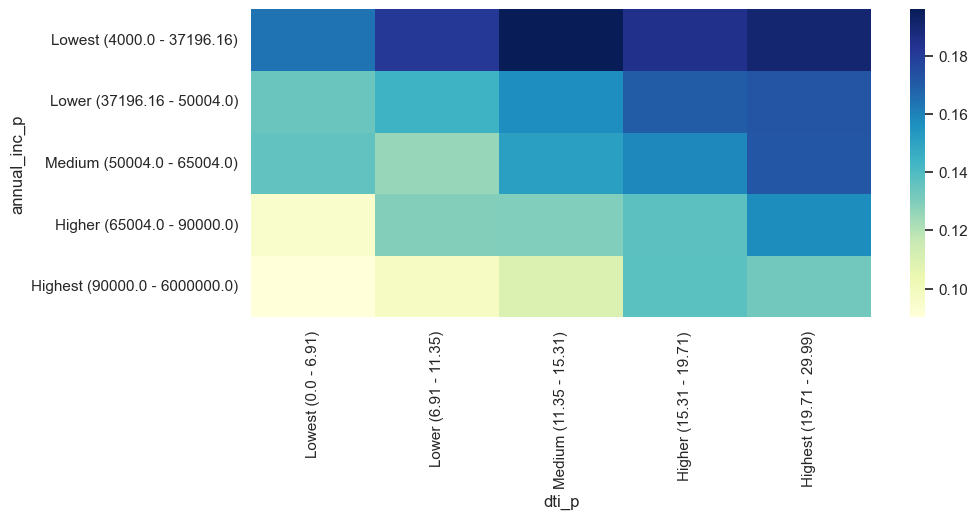

In [97]:
Bivariate_Categorical(x='dti_p', y='annual_inc_p', figsize=(10,4))

Medium debt-to-income group in the lowest income range is the most risky when it comes to loan repayment.

 Hereby we come to an end of the EDA of the loan data set and finding some of the drivers for loan default. Apart from the ones highlighted below, I am sure there will be multiple others too; however, according to me, these are the most impactful ones.

<b>Minor Impact</b> <br>
.Higher loan amount (above 16K) <br>
•Higher installment amount (above 327) <br>
•Lower annual income (below 37K)<br> 
•Higher debt to income ratio (above 15%) <br>
•Applicant’s address state (NV, SD, AK, FL, etc.) <br>
•Loan issue month (Dec, May, Sep)<br>

<b>Heavy impact</b> <br>
•Higher interest rate (above 13%) <br>
•Higher revolving line utilization rate (above 58%) <br>
•Repayment term (5 years)<br> 
•Loan grade & sub-grade (D to G) <br>
•Missing employment record<br> 
•Loan purpose (small business, renewable energy, educational) <br>
•Derogatory public records (1 or 2) <br>
•Public bankruptcy records (1 or 2)<br>

<b>Combined impact</b> <br>
•High loan amount & interest rate for lower income group <br>
•High installment and longer repayment term <br>
•Home ownership (other) and loan purpose (car, moving or small business) <br>
•Residential state and loan purpose<br> 
•Income group and loan purpose<br>
